In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

%matplotlib notebook

In [2]:
import factorization_machine as fm
import util
import imp

In [120]:
df_train = pd.read_csv('../data/ml-100k/ua.base', header=None, names=['uid', 'sid', 'score', 'ts'], sep='\t')

In [121]:
df_test = pd.read_csv('../data/ml-100k/ua.test', header=None, names=['uid', 'sid', 'score', 'ts'], sep='\t')

In [122]:
!wc -l ../data/ml-100k/ua.base

   90570 ../data/ml-100k/ua.base


In [123]:
!wc -l ../data/ml-100k/ua.test

    9430 ../data/ml-100k/ua.test


In [124]:
### MF
X_base, Y_base = util.load_dataset_mf('../data/ml-100k/ua.base', user_cnt=943, item_cnt=1682, entry_cnt=90570)
X_test, Y_test = util.load_dataset_mf('../data/ml-100k/ua.test', user_cnt=943, item_cnt=1682, entry_cnt=9430)

In [ ]:
### SVD++
#X_base, Y_base = util.load_dataset_svd('../data/ml-100k/ua.base', user_cnt=943, item_cnt=1682, entry_cnt=90570)
#X_test, Y_test = util.load_dataset_svd('../data/ml-100k/ua.test', user_cnt=943, item_cnt=1682, entry_cnt=9430)

In [ ]:
### Alternative Least Square Regression

In [125]:
X_train, X_dev, y_train, y_dev = train_test_split(X_base, Y_base)
y_test = Y_test

<IPython.core.display.Javascript object>


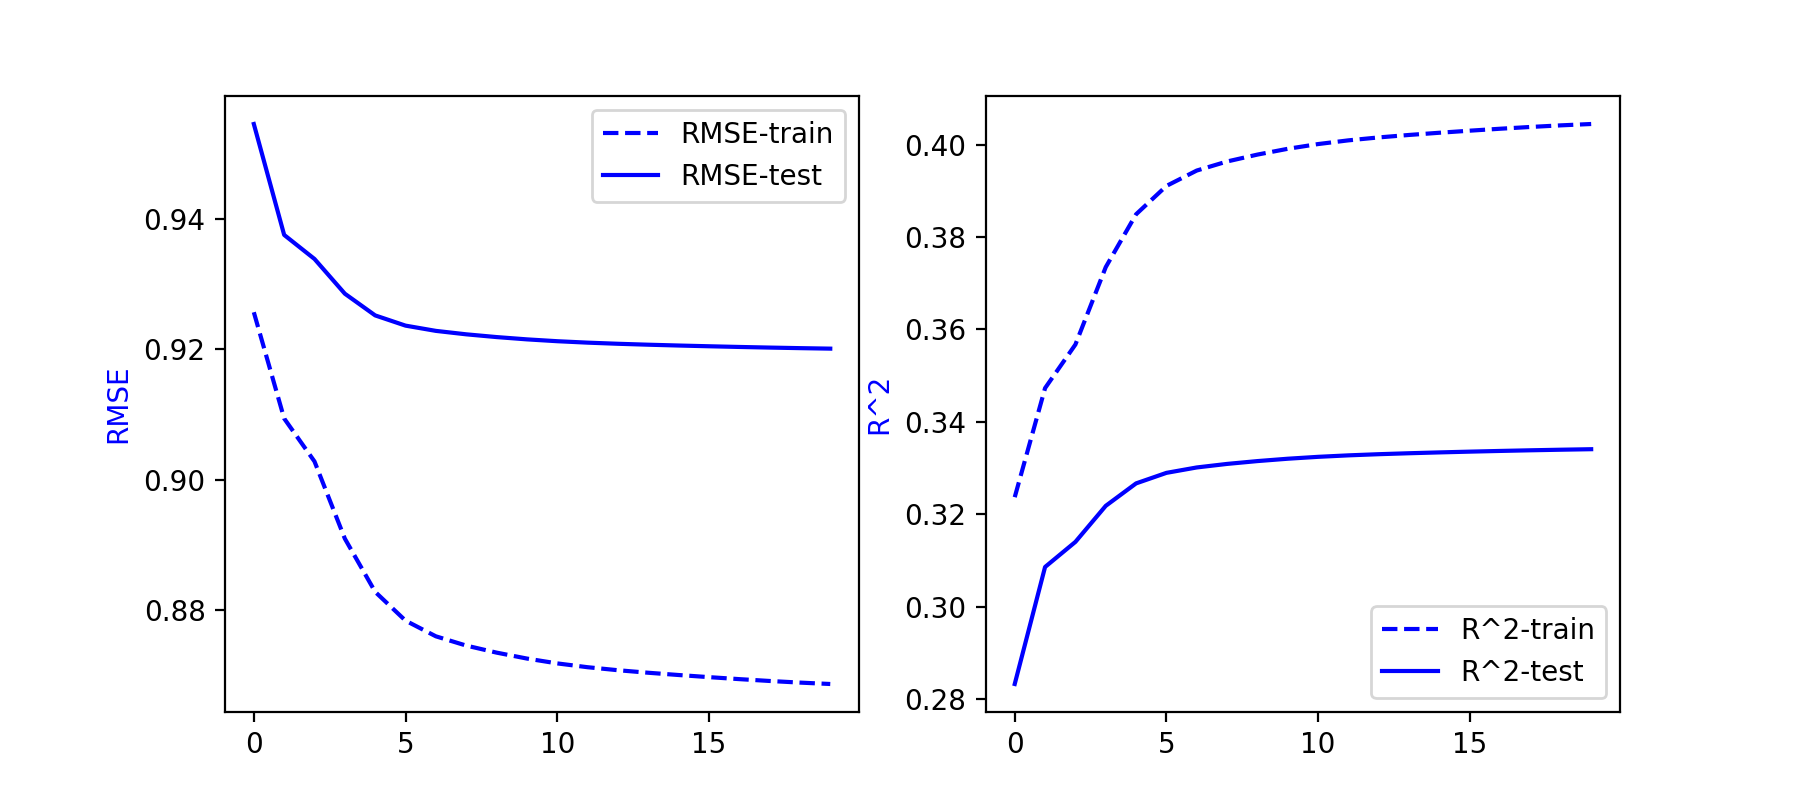

In [126]:
fm = imp.reload(fm)
model = fm.create_model(alg="als", type="regression", n_iter=0, init_stdev=0.1, l2_reg_w=2.1,
                          l2_reg_V=20.1, rank=5, step_size=0.01)
fm.train(model, X_train, y_train, X_dev, y_dev, alg="als", type="regression",
         epoch=20, step_size=1, trace_graph=True)

In [127]:
ytr = util.evaluate_regression(model, X_train, y_train)
print(list(zip(ytr[:5], y_train[:5])))
yde = util.evaluate_regression(model, X_dev, y_dev)
print(list(zip(yde[:5], y_dev[:5])))
yte = util.evaluate_regression(model, X_test, Y_test)
print(list(zip(yte[:5], y_test[:5])))

mse: 0.754540098202
r2 : 0.404446417724
[(3.9602745524560303, 5.0), (3.4429269850704061, 3.0), (3.2261797530162513, 4.0), (2.8495727317757544, 3.0), (4.3335296185262902, 5.0)]
mse: 0.846527411626
r2 : 0.33408945239
[(3.6072871997050178, 3.0), (3.8142974662572477, 5.0), (3.5067757781522029, 4.0), (3.2087589149604479, 5.0), (3.7936926718687531, 3.0)]
mse: 0.911167928238
r2 : 0.273856107236
[(3.4500333174287272, 4.0), (3.4682986645099301, 4.0), (4.0344285463506786, 4.0), (3.5990362898128718, 3.0), (2.7973700599398486, 2.0)]


In [ ]:
### Alternative Least Square Classification

In [128]:
y_base = np.ones_like(Y_base)
y_test = np.ones_like(Y_test)
y_base[Y_base < np.mean(Y_base)] = 0
y_base[Y_base >= np.mean(Y_base)] = 1
y_test[Y_test < np.mean(Y_test)] = 0
y_test[Y_test >= np.mean(Y_base)] = 1
X_train, X_dev, y_train, y_dev = train_test_split(X_base.tocsr(), y_base)

In [129]:
# check balance
print('threshold', np.mean(Y_base))
print(np.count_nonzero(y_train)/len(y_train))
print(np.count_nonzero(y_dev)/len(y_dev))
print(np.count_nonzero(y_test)/len(y_test))
# set up negative labels
y_train[y_train == 0] = -1
y_dev[y_dev == 0] = -1
y_test[y_test == 0] = -1

threshold 3.52383
0.5518129756944956
0.548646380779932
0.5799575821845175


<IPython.core.display.Javascript object>


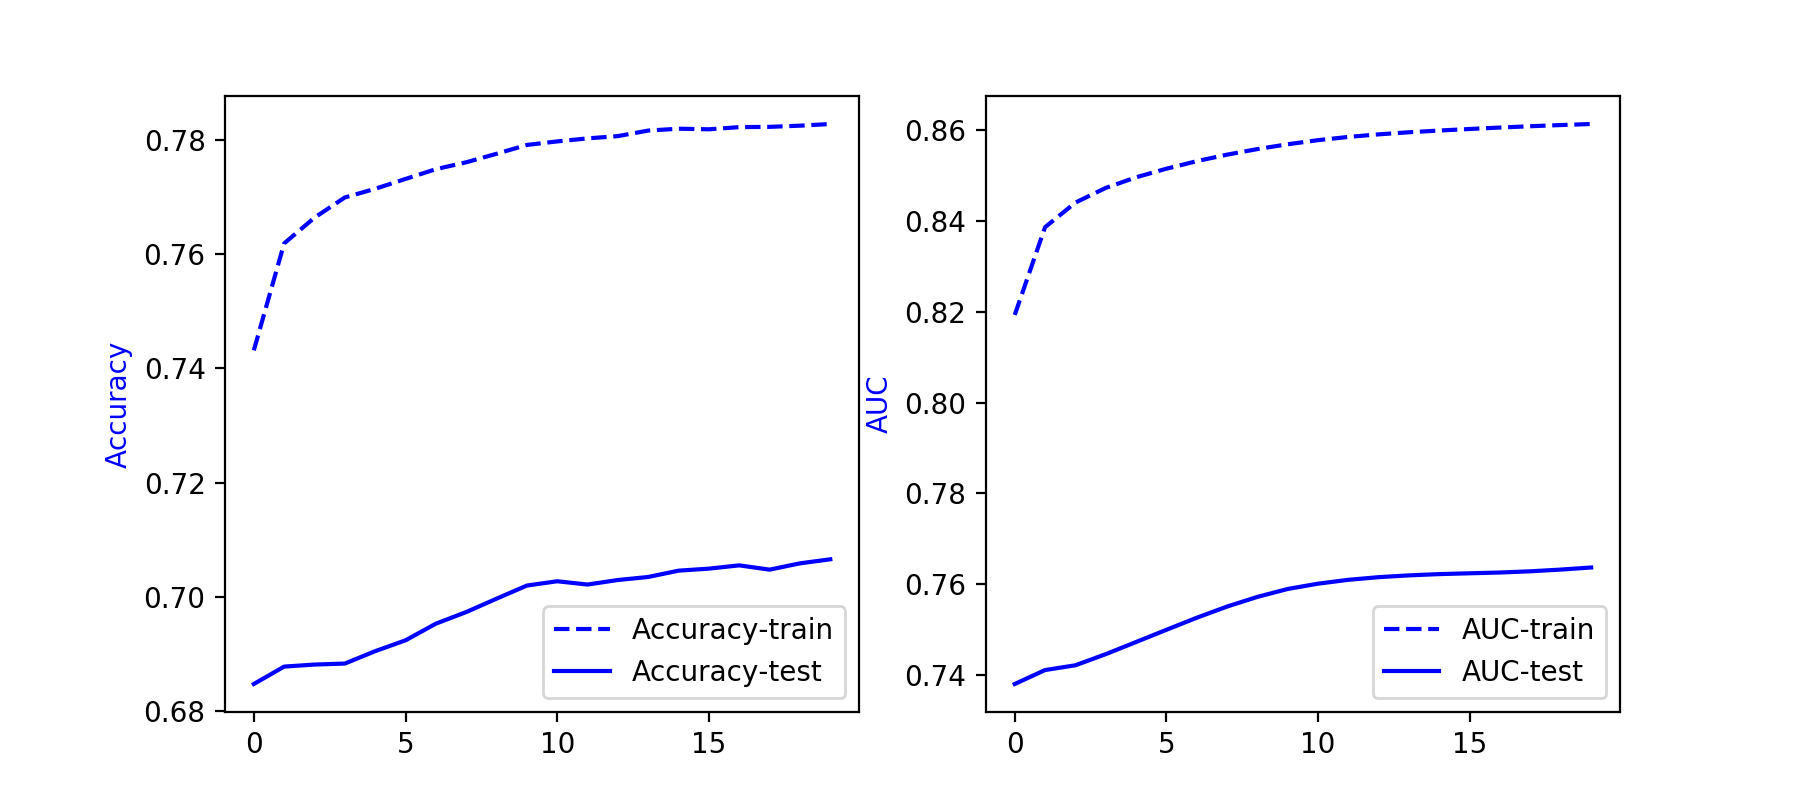

In [130]:
fm = imp.reload(fm)
model = fm.create_model(alg="als", type="classification", n_iter=0, init_stdev=0.1, l2_reg_w=0.1,
                          l2_reg_V=0.1, rank=2, step_size=0.1)
fm.train(model, X_train, y_train, X_dev, y_dev, alg="als", type="classification",
         epoch=20, step_size=1, trace_graph=True)

In [131]:
ytr = util.evaluate_classification(model, X_train, y_train)
print(list(zip(ytr[:5], y_train[:5])))
yde = util.evaluate_classification(model, X_dev, y_dev)
print(list(zip(yde[:5], y_dev[:5])))
yte = util.evaluate_classification(model, X_test, y_test)
print(list(zip(yte[:5], y_test[:5])))

acc: 0.782737350391
auc: 0.861323687077
[(0.70242044119013836, 1.0), (0.42748554567942609, 1.0), (0.3449365443764878, -1.0), (0.55054241136315052, -1.0), (0.79309212311193211, 1.0)]
acc: 0.706575983748
auc: 0.763697618032
[(0.72627857243942973, -1.0), (0.63482714965715814, 1.0), (0.31384065319573407, -1.0), (0.63489465180214544, 1.0), (0.49056476381580133, -1.0)]
acc: 0.685683987275
auc: 0.731558550687
[(0.68838250969961101, 1.0), (0.35277477419836406, 1.0), (0.39071587804516017, 1.0), (0.47336206870306119, -1.0), (0.3920229775767497, -1.0)]


In [ ]:
### Multi-Layer Percepton Matrix Factorization

In [112]:
import mxnet as mx
from mxnet import gluon, nd
from sklearn.model_selection import train_test_split
import mlpmf

In [113]:
mlpmf = imp.reload(mlpmf)
user_cnt=943
item_cnt=1682
rank = 64
batch_size = 64

In [114]:
uid_train, uid_dev, sid_train, sid_dev, score_train, score_dev = \
    train_test_split(*util.load_dataset_raw('../data/ml-100k/ua.base'), test_size=0.1)
uid_test, sid_test, score_test = util.load_dataset_raw('../data/ml-100k/ua.test')

In [115]:
dataset_train = gluon.data.ArrayDataset(uid_train, sid_train, score_train)
dataset_dev = gluon.data.ArrayDataset(uid_dev, sid_dev, score_dev)
dataset_test = gluon.data.ArrayDataset(uid_test, sid_test, score_test)

In [116]:
dataiter_train = gluon.data.DataLoader(dataset_train, shuffle=True, batch_size=batch_size)
dataiter_dev = gluon.data.DataLoader(dataset_dev, shuffle=True, batch_size=batch_size)
dataiter_test = gluon.data.DataLoader(dataset_test, shuffle=True, batch_size=batch_size)

In [117]:
model = mlpmf.FactorizationBlock(user_cnt, item_cnt, rank)
model.collect_params().initialize(init=mx.init.Xavier(), ctx=mx.cpu(), force_reinit=True)

In [118]:
mlpmf.evaluate_network(model, dataiter_test, ctx=mx.cpu())

3.7434749216646761

Epoch 0: 
  RMSE training set: 1.1931808993243722 dev set: 1.1985462433855298, test set: 1.1834370771775375
Epoch 1: 
  RMSE training set: 1.212200863067546 dev set: 1.2138553320522039, test set: 1.1995366505674414
Epoch 2: 
  RMSE training set: 1.2466386438258215 dev set: 1.2499489859795907, test set: 1.2175546425419885


<IPython.core.display.Javascript object>


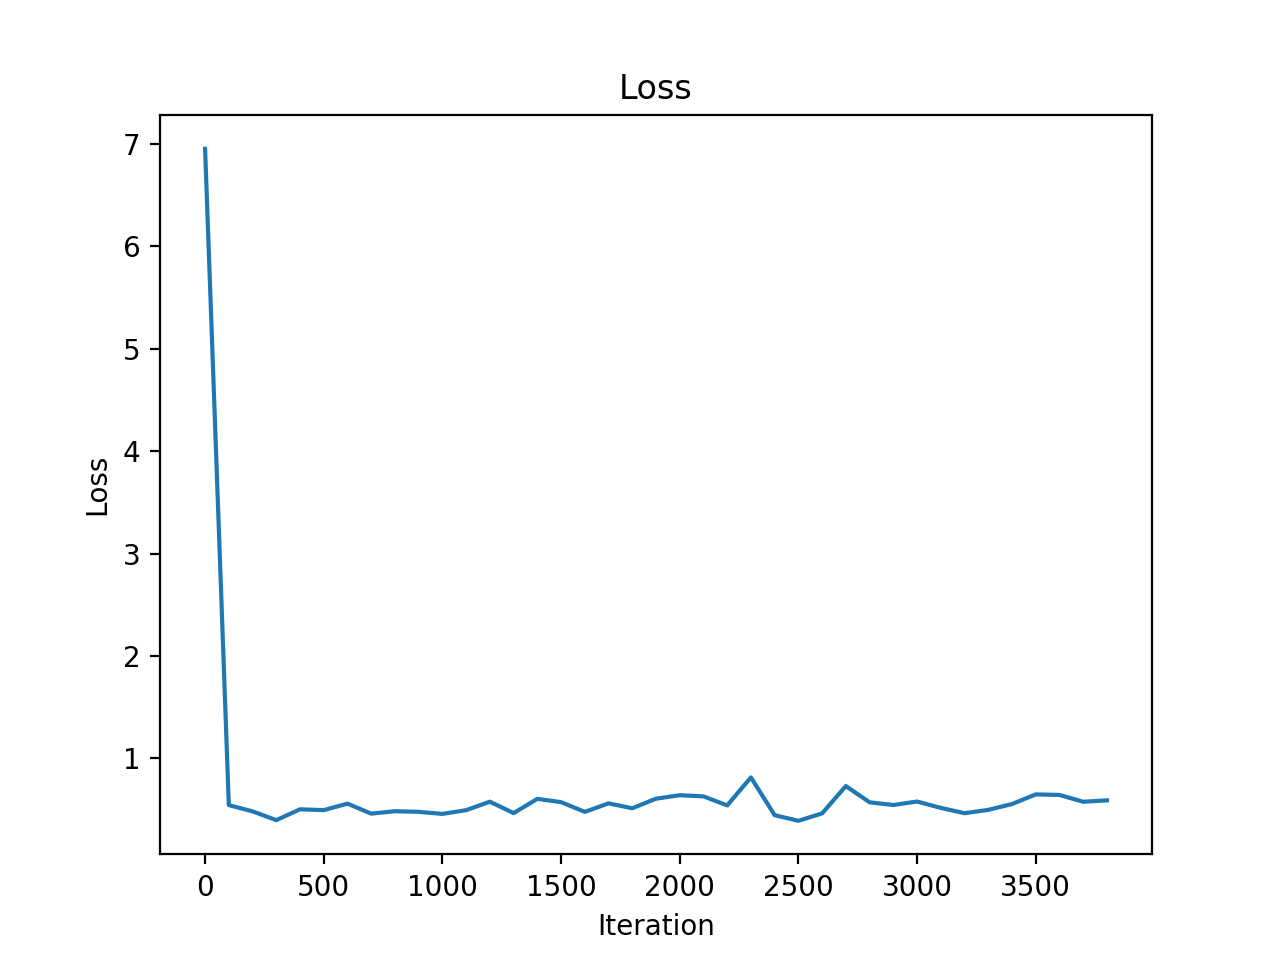

In [119]:
mlpmf.train(model, dataiter_train, dataiter_dev, dataiter_test, epoches=3)

In [ ]:
### Multi-Layer Percepton Matrix Factorization - Classification

In [105]:
mlpmf = imp.reload(mlpmf)
user_cnt=943
item_cnt=1682
rank = 5
batch_size = 64

In [106]:
uid_train, uid_dev, sid_train, sid_dev, score_train, score_dev = \
    train_test_split(*util.load_dataset_raw('../data/ml-100k/ua.base'), test_size=0.1)
uid_test, sid_test, score_test = util.load_dataset_raw('../data/ml-100k/ua.test')

In [107]:
threshold = np.mean(score_train)
score_train[score_train < threshold] = 0
score_train[score_train >= threshold] = 1
score_dev[score_dev < threshold] = 0
score_dev[score_dev >= threshold] = 1
score_test[score_test < threshold] = 0
score_test[score_test >= threshold] = 1

score_train = score_train.astype('int32')
score_dev = score_dev.astype('int32')
score_test = score_test.astype('int32')

In [108]:
dataset_train = gluon.data.ArrayDataset(uid_train, sid_train, score_train)
dataset_dev = gluon.data.ArrayDataset(uid_dev, sid_dev, score_dev)
dataset_test = gluon.data.ArrayDataset(uid_test, sid_test, score_test)
dataiter_train = gluon.data.DataLoader(dataset_train, shuffle=True, batch_size=batch_size)
dataiter_dev = gluon.data.DataLoader(dataset_dev, shuffle=True, batch_size=batch_size)
dataiter_test = gluon.data.DataLoader(dataset_test, shuffle=True, batch_size=batch_size)

In [109]:
model = mlpmf.FactorizationBlock(user_cnt, item_cnt, rank, type='classification')
model.collect_params().initialize(init=mx.init.Xavier(), ctx=mx.cpu(), force_reinit=True)

In [110]:
mlpmf.evaluate_network(model, dataiter_test, ctx=mx.cpu(), type='classification')

0.49459172852598093

Epoch 0: 
  Accuracy training set: 0.5507465066921841 dev set: 0.5534945346141106, test set: 0.5799575821845175
Epoch 1: 
  Accuracy training set: 0.5507465066921841 dev set: 0.5534945346141106, test set: 0.5799575821845175
Epoch 2: 
  Accuracy training set: 0.5507465066921841 dev set: 0.5534945346141106, test set: 0.5799575821845175


<IPython.core.display.Javascript object>


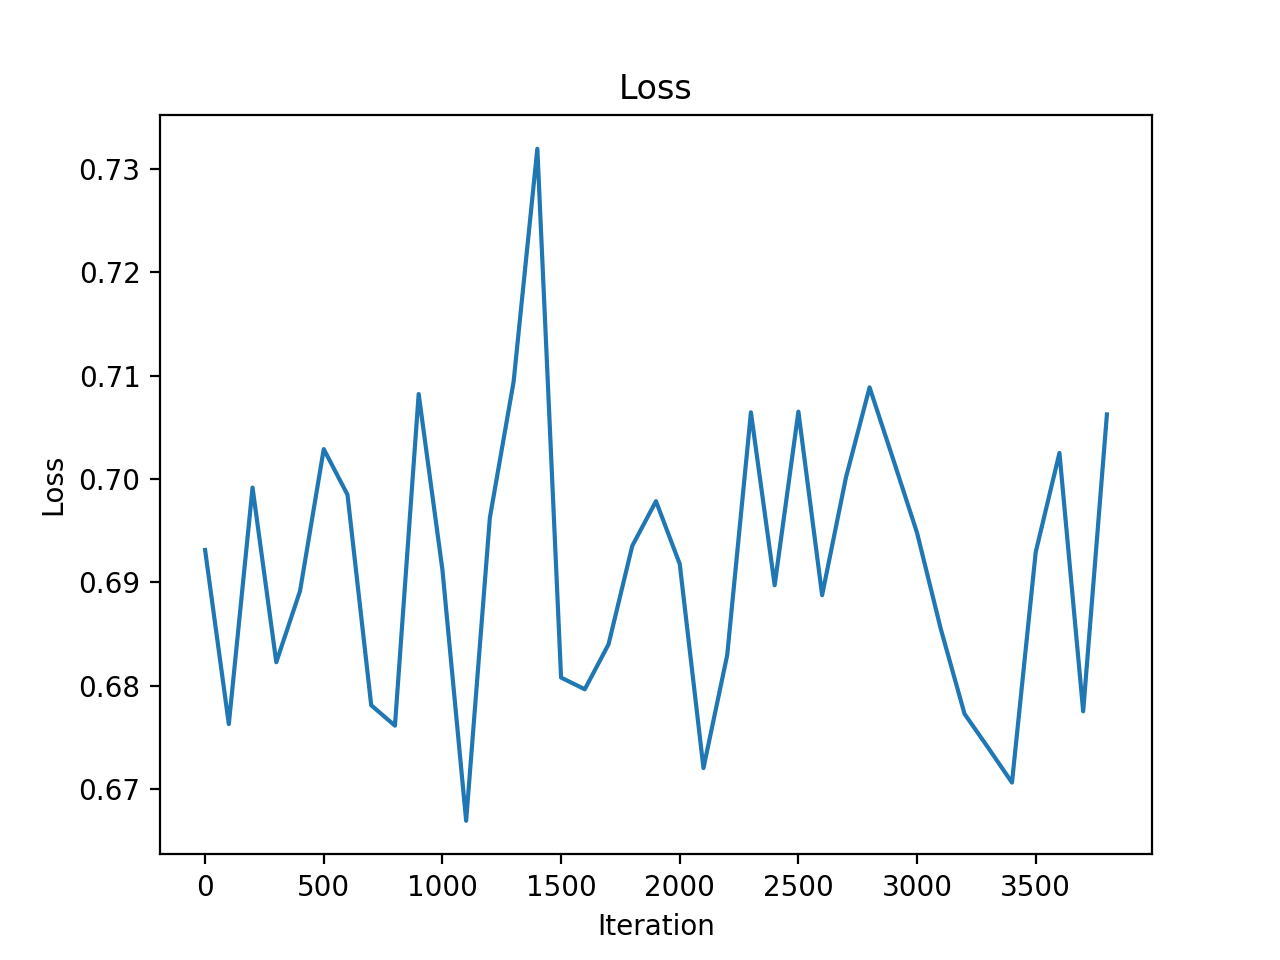

In [111]:
mlpmf.train(model, dataiter_train, dataiter_dev, dataiter_test, epoches=3, type='classification')